# Определение перспективного тарифа для телеком компании

## Описание проекта

Нам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Описание тарифов
**Тариф «Смарт»**
1. Ежемесячная плата: 550 рублей
2. Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:  
    * минута разговора: 3 рубля
    * сообщение: 3 рубля
    * 1 Гб интернет-трафика: 200 рублей  

**Тариф «Ультра»**
1. Ежемесячная плата: 1950 рублей
2. Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3. Стоимость услуг сверх тарифного пакета:  
    * минута разговора: 1 рубль
    * сообщение: 1 рубль
    * 1 Гб интернет-трафика: 150 рублей  

*Обратите внимание: «Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.*

## Описание данных  
Таблица `users` (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица `calls` (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица `messages` (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица `internet` (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица `tariffs` (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

## Постановка задачи
### Шаг 1. Открыть файл с данными и изучить общую информацию
### Шаг 2. Предобработка данных
- [x] Привести данные к нужным типам;
- [x] Найти и исправить ошибки в данных;

### Шаг 3. Посчитать и добавить в таблицу
- [x] Количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x] Количество отправленных сообщений по месяцам;
- [x] Объем израсходованного интернет-трафика по месяцам;
- [x] Помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану);

### Шаг 4. Проанализировать данные

### Шаг 5. Проверить гипотезы
- [x] Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
- [x] Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.
---

## Решение
## <a name="1">Шаг 1</a>. Открыть файл с данными и изучить общую информацию

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
# загружаем датафреймы в переменные
pd.set_option('display.max_columns', None)
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv', index_col=0)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')
# вывыдем общую информацую по датафреймам

info = [calls, internet, messages, tariffs, users]
for data in info:
    print(data.info(), sep='\n', end='\n\n'),

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0

### Промежуточный вывод

Датасет содержит в себе записи о пятистах клиентах. Все столбцы с датами имеет неверный тип данных. Далее" нам предстоит поменять тип данных для столбцов с датами. Т.к. тарифы считают интернет трафик в мегабайтах, а время разговоров в минутах необходимо округлить данные значения в большую сторону.  
Помимо прочего, после объединения таблиц возможно встретить пустые значения (клиент мог не писать сообщений в данном месяце), их предстоит заменить на нули.

---

## <a name="2">Шаг 2</a>. Предобработка данных

Поставим везде правильный формат даты и времени.

In [2]:
# меняем тип данных на datetime
calls['call_date'] = pd.to_datetime(calls['call_date'], format = '%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format = '%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format = '%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format = '%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format = '%Y-%m-%d')

**Исправление ошибок в данных.**

In [3]:
print('Количество звонков с длительностью = 0:', calls.loc[calls['duration'] == 0, 'duration'].value_counts()[0])

Количество звонков с длительностью = 0: 39613


Добавим столбец со значениями месяца.

In [4]:
calls['month'] = calls['call_date'].dt.month

Построим график зависимости общего числа звонков от количеств нулевых значений за каждый месяц.

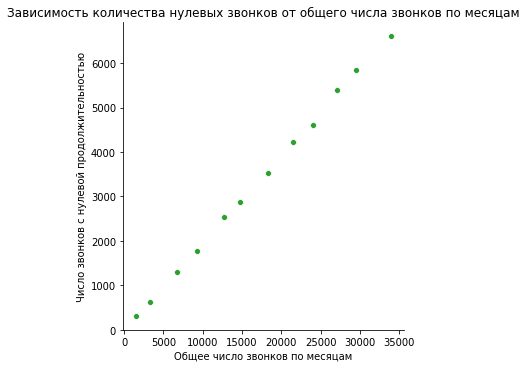

In [5]:
# для этого создадим столбец для индетификации нулевых значений и подсчета
calls.loc[calls['duration'] == 0, 'nulls_count'] = 1 
null_calls = calls.pivot_table(index = 'month', values =['id', 'nulls_count'], aggfunc = 'count')

# строим график
sns.relplot(x = 'id', y = 'nulls_count', data = null_calls, color='tab:green')
plt.xlabel('Общее число звонков по месяцам')
plt.ylabel('Число звонков с нулевой продолжительностью')
_ = plt.title('Зависимость количества нулевых звонков от общего числа звонков по месяцам')

На графике видно, что количество нулевых звонков имеет линейный рост, а появляются они систематически. Округлим минуты разговоров в большую сторону, а нули заменим на единицы, т.к. оператор именно так и считает.

In [6]:
calls['duration'] = calls['duration'].apply(np.ceil)
calls.loc[calls['duration'] == 0, 'duration'] = 1

Далее проведем осмотрим таблицу о интернет-сессиях.   

In [7]:
print('Количество интернет сессий с расходом трафика = 0:', internet.loc[internet['mb_used'] == 0, 'mb_used'].value_counts()[0])

Количество интернет сессий с расходом трафика = 0: 19598


Для начала создадим столбец с месяцами.

In [8]:
internet['month'] = internet['session_date'].dt.month

Построим график зависимости всех значей от нулевых столбца расхода сетевого трафика.

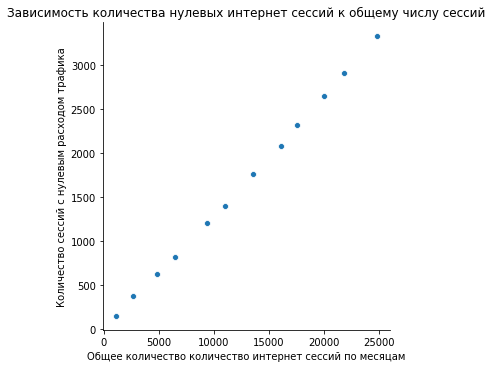

In [9]:
# создадим столбец с признаком нулевого трафика
internet.loc[internet['mb_used'] == 0, 'nulls_count'] = 1

# создадим сводную таблицу для подсчета количества нулевых значений по месяцам
null_mb = internet.pivot_table(index = 'month', values = ['id', 'nulls_count'], aggfunc = 'count')

# строим график
sns.relplot(x = 'id', y = 'nulls_count', data = null_mb, color='tab:blue')
plt.xlabel('Общее количество количество интернет сессий по месяцам')
plt.ylabel('Количество сессий с нулевым расходом трафика')
_ = plt.title('Зависимость количества нулевых интернет сессий к общему числу сессий')

На графике абсолютно такая же зависимость, как и в случае "нулевых" звонков, поялвяются систематически. Округлим все значения вверх (тариф считается по мегабайтам), а нулевые значения заменим на единицы.

In [10]:
internet['mb_used'] = internet['mb_used'].apply(np.ceil)
internet.loc[internet['mb_used'] == 0, 'mb_used'] = 1

### Промежуточный вывод

В данном шаге были приведены типы данных в datetime, построены графики зависимостей нулевых значений потребления интернет трафика и минут разговора от общих значений. На графиках видно, что нулевые значения появляются систематически, имеет линейную прогрессию.

---

## <a name="3">Шаг 3</a>. Посчитать и добавить в таблицу

Представим следующие характеристики в одной таблице:
- Количество сделанных звонков и израсходованных минут разговора по месяцам;
- Количество отправленных сообщений по месяцам;
- Объем израсходованного интернет-трафика по месяцам;

Для сведения таблиц создадим столбец с уникальным именем, состоящим из имени и фамилии.

In [11]:
users['unique_name'] = users['first_name'] + ' ' + users['last_name']

Создадим сводную таблицу с продолжительностью и количеством звонков по месяцам.

In [12]:
# склеиваем таблицу calls и users по user_id
calls_temp = calls.merge(users, on = 'user_id', how = 'inner')
# создаем сводннуб таблицу
calls_group = calls_temp.pivot_table(
    index = ['user_id', 'month'], 
    values = ['unique_name', 'duration'],
    aggfunc = {'unique_name' : 'count', 'duration' : 'sum'}
)
# назначаем наименование столбцов
calls_group.columns = ['duration', 'calls']

Создадим сводную таблицу с количеством отправленнных сообщений по месяцам.

In [13]:
# создаем столбец с номером месяца
messages['month'] = messages['message_date'].dt.month
# склеиваем таблицу messages и users по user_id
messages_temp = messages.merge(users, on = 'user_id', how = 'inner')
# создаем сводную таблицу
messages_group = messages_temp.pivot_table(
    index = ['user_id', 'month'],
    values = 'unique_name',
    aggfunc = 'count'
)
# назначаем наименование столбцов
messages_group.columns = ['messages']

Создадим сводную таблицу с количеством потребляемого интернет трафика.

In [14]:
# склеиваем таблицу internet и users по user_id
internet_temp = internet.merge(users, on = 'user_id', how = 'inner')
# создаем сводную таблицу
internet_group = internet_temp.pivot_table(
    index = ['user_id', 'month'],
    values = 'mb_used',
    aggfunc = 'sum'
)
# назначаем наименование столбцов
internet_group.columns = ['mb_used']

Теперь мы можешь склеить все эти таблицы в одну для дальнейшей работы с ней.

In [15]:
# используем функцию reduce, т.к. она комбинирует все параметры поллученные на входе
from functools import reduce
# что будем склеивать
for_good_data = [calls_group, messages_group, internet_group]
# склеиваем
good_data = reduce(lambda x, a: pd.merge(x, a, on = ['user_id', 'month'], how = 'outer'), for_good_data)
good_data.head(9)

duration  calls  messages  mb_used
user_id month                                    
1000    5         164.0   22.0      22.0   2257.0
        6         187.0   43.0      60.0  23262.0
        7         346.0   47.0      75.0  14017.0
        8         418.0   52.0      81.0  14072.0
        9         478.0   58.0      57.0  14583.0
        10        363.0   57.0      73.0  14717.0
        11        344.0   43.0      58.0  14769.0
        12        341.0   46.0      70.0   9829.0
1001    11        444.0   59.0       NaN  18460.0

Остались пропущенные значения, их заменим на нуль.

In [16]:
good_data.loc[good_data['duration'].isna(), 'duration'] = 0
good_data.loc[good_data['calls'].isna(), 'calls'] = 0
good_data.loc[good_data['messages'].isna(), 'messages'] = 0
good_data.loc[good_data['mb_used'].isna(), 'mb_used'] = 0

Добавим в таблицу информацию о тарифах пользователей.

In [17]:
for n in good_data.index.levels[0]:
    good_data.loc[n, 'tariff'] = users.loc[n - 1000, 'tariff']

In [18]:
good_data.sample(5)

,,duration,calls,messages,mb_used,tariff
user_id,month,,,,,
1360,10,836.0,113.0,0.0,11076.0,ultra
1158,2,377.0,45.0,55.0,12738.0,smart
1000,8,418.0,52.0,81.0,14072.0,ultra
1232,10,239.0,30.0,25.0,8516.0,smart
1429,12,249.0,34.0,0.0,21564.0,smart


Теперь мы можем подсчитать помесячную выручку с каждого пользователя. Вычтем бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика, остаток умножим на значение из тарифного плана, прибавем абонентскую плату, соответствующую тарифному плану.

Для подсчета напишем функцию и применим ее к датафрейму с 'хорошими данными'.

In [19]:
def revenue(row):
    '''Return monthly revenue per user
    
    Subtracts the free limit from the total number of calls,
    messages and Internet traffic,
    multiplies the remainder by the value from the tariff plan,
    adds the subscription fee.
    '''
    messages = row['messages']
    mb_used = row['mb_used']
    tariff = row['tariff']
    duration = row['duration']
    calls = row['calls']
    if tariff == 'smart': # если тариф smart
        duration_over = duration - tariffs.loc[0, 'minutes_included']
        messages_over = messages - tariffs.loc[0, 'messages_included']
        mb_used_over = mb_used - tariffs.loc[0, 'mb_per_month_included']
        # проверка на отрицательное значение
        if duration_over < 0:
            duration_over = 0
        if messages_over < 0:
            messages_over = 0
        if mb_used_over < 0:
            mb_used_over = 0
        return round((duration_over * tariffs.loc[0, 'rub_per_minute']) # возвращаем округленное по формуле число
                + (messages_over * tariffs.loc[0, 'rub_per_message']) 
                + (mb_used_over * (tariffs.loc[0, 'rub_per_gb'] / 1024) 
                + tariffs.loc[0, 'rub_monthly_fee']), 1
                )
    elif tariff == 'ultra': # если тариф ultra
        duration_over = duration - tariffs.loc[1, 'minutes_included']
        messages_over = messages - tariffs.loc[1, 'messages_included']
        mb_used_over = mb_used - tariffs.loc[1, 'mb_per_month_included']
        # проверка на отрицательное значение
        if duration_over < 0:
            duration_over = 0
        if messages_over < 0:
            messages_over = 0
        if mb_used_over < 0:
            mb_used_over = 0
        return round((duration_over * tariffs.loc[1, 'rub_per_minute']) # возвращаем округленное по формуле число
                + (messages_over * tariffs.loc[1, 'rub_per_message'])
                + (mb_used_over * (tariffs.loc[1, 'rub_per_gb'] / 1024)
                + tariffs.loc[1, 'rub_monthly_fee']), 1
                )

In [20]:
good_data['revenue'] = good_data.apply(revenue, axis = 1)

In [21]:
good_data.head()

duration  calls  messages  mb_used tariff  revenue
user_id month                                                    
1000    5         164.0   22.0      22.0   2257.0  ultra   1950.0
        6         187.0   43.0      60.0  23262.0  ultra   1950.0
        7         346.0   47.0      75.0  14017.0  ultra   1950.0
        8         418.0   52.0      81.0  14072.0  ultra   1950.0
        9         478.0   58.0      57.0  14583.0  ultra   1950.0

### Промежуточный вывод
В данном шаге мы посчитали количество сделанных звонков и израсходованных минут разговора по месяцам, количество отправленных сообщений по месяцам, объем израсходованного интернет-трафика по месяцам, помесячную выручку с каждого пользователя.

## <a name="4">Шаг 4</a>. Проанализировать данные
Теперь выведем таблицу со медианными показателями потребления тарифов в месяца.

In [22]:
median_data = good_data.pivot_table(
    index = 'user_id',
    values = ['duration', 'calls', 'messages', 'mb_used', 'revenue'],
    aggfunc = 'median'
)
# добавим информацию о тарифах
for n in median_data.index:
    median_data.loc[n, 'tariff'] = users.loc[n - 1000, 'tariff']
median_data.head()

,calls,duration,mb_used,messages,revenue,tariff
user_id,,,,,,
1000,46.5,345.0,14327.5,65.0,1950.00,ultra
1001,61.0,437.0,16259.5,0.0,852.75,smart
1002,33.0,221.0,17615.0,11.0,990.40,smart
1003,108.0,844.0,11369.0,83.0,1950.00,ultra
1004,21.5,136.5,17831.0,154.5,1950.00,ultra


Выведем среднее количество, дисперсию и стандартное отколонение для показателей.

In [23]:
stats_median_data = median_data.pivot_table(
    index = 'tariff', 
    values = ['calls', 'duration', 'mb_used', 'messages', 'revenue'],
    aggfunc = ['mean', 'var', 'std']
)
stats_median_data.head()

mean                                                    \
            calls    duration       mb_used   messages      revenue   
tariff                                                                
smart   61.814286  449.885714  16862.307143  33.770000  1261.739000   
ultra   77.912162  572.820946  20324.445946  56.983108  2050.283784   

                var                                                          \
              calls      duration       mb_used     messages        revenue   
tariff                                                                        
smart    507.112976  27097.876586  1.748493e+07   784.596662  510110.178167   
ultra   1783.492232  97026.949014  7.924517e+07  2424.263318   75535.005416   

              std                                                  
            calls    duration      mb_used   messages     revenue  
tariff                                                             
smart   22.519169  164.614327  4181.498288  28.010653  714.219979  
ultra   42.231413  311.491491  8901.975727  49.236809  274.836325

Построим диаграммы размаха для каждого тарифа по продолжительности звонков, количеству сообщений и израсходованному интернет трафику.

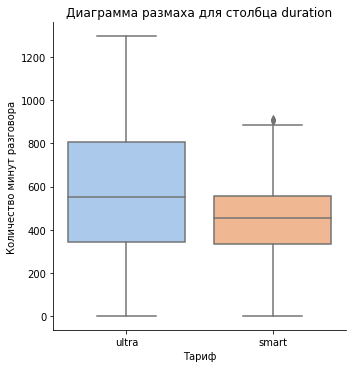

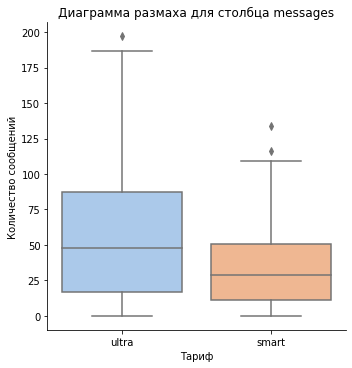

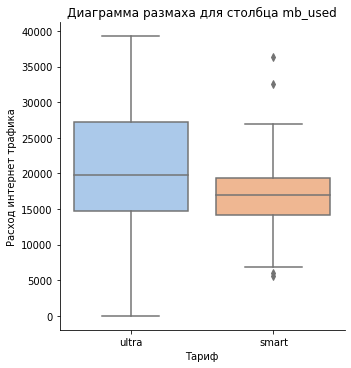

In [24]:
keywords = {'duration' : 'Количество минут разговора', 'messages' : 'Количество сообщений', 'mb_used' : 'Расход интернет трафика'}
for column in ['duration', 'messages', 'mb_used']:
    sns.catplot(data = median_data, x = 'tariff', y = column, kind = 'box', palette="pastel")
    plt.xlabel('Тариф')
    plt.ylabel(keywords[column])
    plt.title('Диаграмма размаха для столбца ' + column)

На диаграммах размаха видно, что по всем характеристикам (минуты разговоров, количество сообщений и расход интернет трафика) тариф "Ультра" имеет большую дисперсию в сравнении с тарифом "Смарт", медианное значение смещено в большую сторону, значит клиенты с тарифом "Ультра" расходуют в среднем больше. К тому же количество выбросов на тарифе "Смарт" значительно больше. 

Построим гистограммы распределения основных показателей для обоих тарифов.

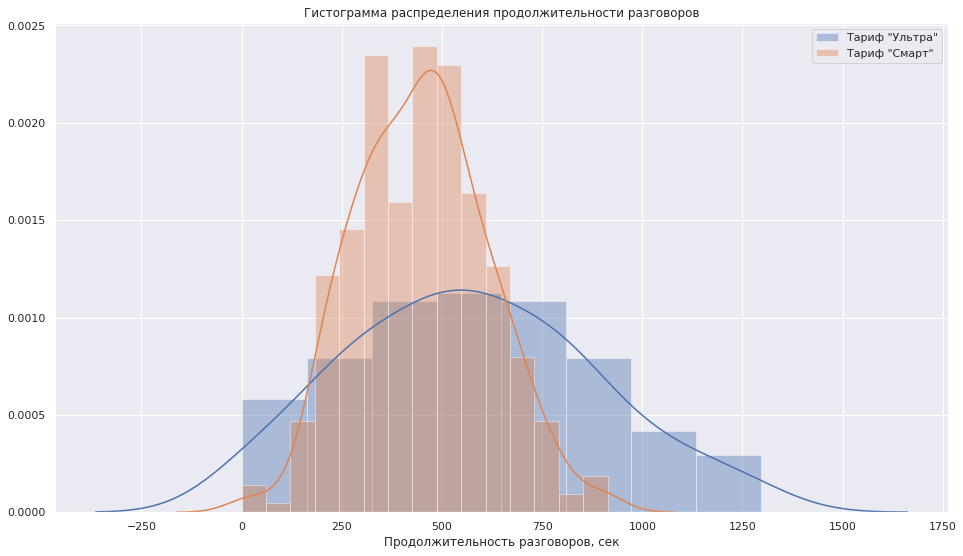

In [25]:
for tariff in ['ultra', 'smart']:
    sns.set(rc={'figure.figsize':(16,9)})
    sns.distplot(median_data.query('tariff == @tariff')['duration'])
    plt.legend(['Тариф "Ультра"', 'Тариф "Смарт"'])
    plt.title('Гистограмма распределения продолжительности разговоров')
    plt.xlabel('Продолжительность разговоров, сек')

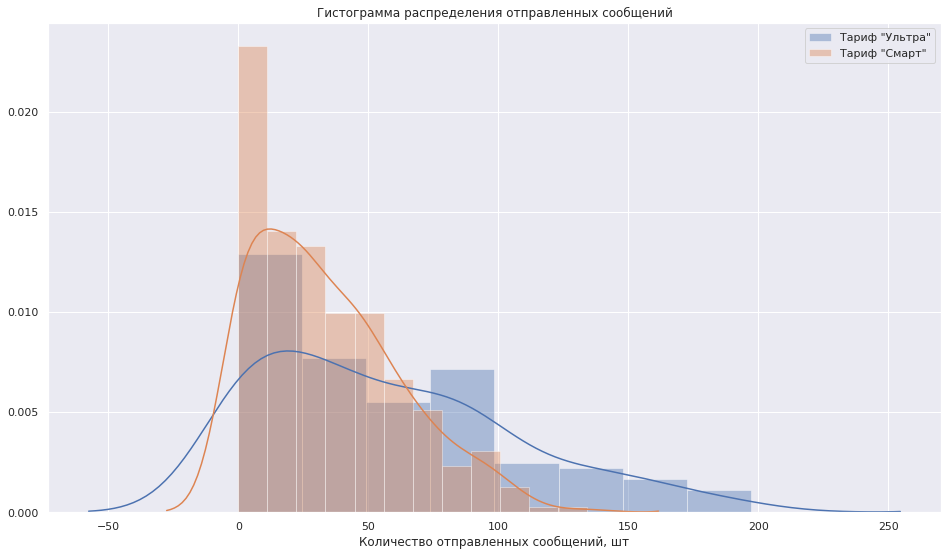

In [26]:
for tariff in ['ultra', 'smart']:
    sns.set(rc={'figure.figsize':(16,9)})
    sns.distplot(median_data.query('tariff == @tariff')['messages'])
    plt.legend(['Тариф "Ультра"', 'Тариф "Смарт"'])
    plt.title('Гистограмма распределения отправленных сообщений')
    plt.xlabel('Количество отправленных сообщений, шт')

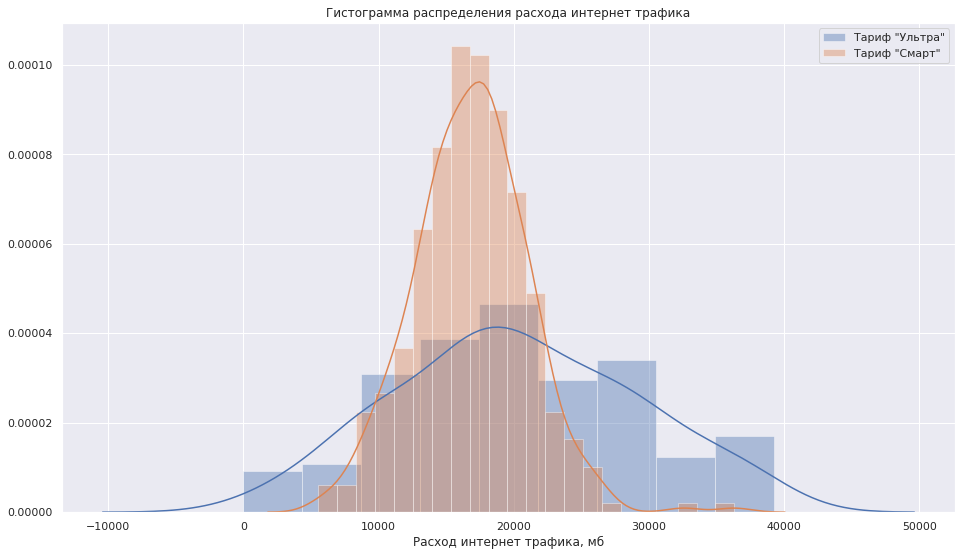

In [27]:
for tariff in ['ultra', 'smart']:
    sns.set(rc={'figure.figsize':(16,9)})
    sns.distplot(median_data.query('tariff == @tariff')['mb_used'])
    plt.legend(['Тариф "Ультра"', 'Тариф "Смарт"'])
    plt.title('Гистограмма распределения расхода интернет трафика')
    plt.xlabel('Расход интернет трафика, мб')

### Промежуточный вывод

Из полученных графиков можно сделать вывод, что дисперсия больше у тарифа "Ултра", чем у тарифа "Смарт" по всем параметрам. Судя по диаграммам размаха и гистограмм, распределение близко к нормальному. Исходя из этого, можно сделать вывод, что **пользователи тарифа "Ультра" потребляют больше телекомуникационных услуг**. Возможно использование тарифа, где предполагается больший запас трафика, минут и количества сообщений включенных по-умолчанию позволяет клиентам охотнее их тратить.

Стандартное отклонение по выручке в тарифе "Смарт" в 714 рублей говорит о большом разбросе оплаты. Пользователи данного тарифа в среднем больше переплачивают сверх лимита.

**Сколько в среднем требуется пользователям минут разговора, сообщений и интернет трафика для каждого тарифа?**

Величина | Название тарифа | Сколько требуется
:-----|:---------|:------
Минут разговора, сек     | Ультра     | 573
     | Смарт     | 450
Количество сообщений, шт     | Ультра  | 57
 | Смарт | 34
Интернет трафика, мб | Ультра | 20324
 | Смарт | 16862

___

## <a name="5">Шаг 5</a>. Проверить гипотезы
### Проверка гипотез №1

Постановка гипотезы:  
$H{_0} - $ средняя выручка пользователей тарифов "Ультра" и "Смарт" **не различается**.  
$H{_1} - $ средняя выручку пользователей тарифов "Ультра" и "Смарт" **различается**.  
$\alpha = 1$% $-$ критический уровень статистической значимости.  
Если `p-value` меньше порогового значения `alpha`, то гипотезу отвергаем. Иначе - не отвергаем.

Воспользуемся тестом Левина и на основе его результатов будем делать вывод равны ли дисперсии двух выборок.

In [28]:
from scipy.stats import levene
# соберем данные по выручке для каждого тарифа в переменные
smart = good_data.loc[good_data['tariff'] == 'ultra', 'revenue']
ultra = good_data.loc[good_data['tariff'] == 'smart', 'revenue']
# тест Левина
stat, p = levene(smart, ultra)
p

3.3172175151567484e-119

Значение p очень велико, следовательно дисперсии однородны. Можем перейти к проверке гипотезы с помощью t-критерия Стьюдента.

In [29]:
alpha = .01 # критический уровень статистической значимости

result = st.ttest_ind(smart, ultra, equal_var = True)

print('Средняя выручка по тарфу "Ультра": {:.2f}'.format(ultra.mean()),
      'Средняя выручка по тарифу "Смарт": {:.2f}\n'.format(smart.mean()) , sep = '\n')
print('p-значение: {}\n'.format(result.pvalue))

if (result.pvalue > alpha):
    print('Не удалось отвергнуть нулевую гипотезу.')
else:
    print('Отвеграем нулевую гипотезу.')

Средняя выручка по тарфу "Ультра": 1251.41
Средняя выручка по тарифу "Смарт": 2060.59

p-значение: 8.010454520011615e-180

Отвеграем нулевую гипотезу.


Выведем медианную прибыль по тарифам и диаграммы размаха для наглядности.

        revenue
tariff         
smart     987.7
ultra    1950.0


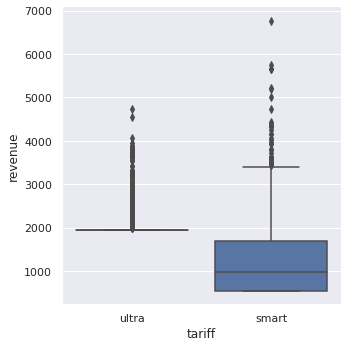

In [30]:
print(good_data.pivot_table(index = 'tariff', values = 'revenue', aggfunc = 'median'))
sns.catplot(x = 'tariff', y = 'revenue', kind = 'box', data = good_data, color = 'b');

### Промежуточный вывод

Медианные значения отличаются для тарифов почти в 2 раза. Пользователям тарифа "Смарт" в среднем не хватает выделенных услуг в рамках пакета и они доплачивают за их расширение. С точностью 99% можно сказать, что пользователи тарифа "Ультра" и "Смарт" приносят компании "Мегалайн" разную выручку.

### Проверка гипотезы №2

Постановка гипотезы:  
$H{_0} - $ Средняя выручка пользователей из Москвы **не отличается** от средней выручки пользователей из других регионов.  
$H{_1} - $ средняя выручку пользователей из Москвы **отличается** от средней выручки пользователей из других регионов.  
$\alpha = 1$% $-$ критический уровень статистической значимости.  
Если `p-value` меньше порогового значения `alpha`, то гипотезу отвергаем. Иначе - не отвергаем.

Добавим в нашу выборку информацию о городе проживания.

In [31]:
for n in good_data.index.levels[0]:
    good_data.loc[n, 'city'] = users.loc[n - 1000, 'city']

Проведем тест Левина для исследования равенста дисперсий.

In [32]:
# сохраним в переменные список выручки клиентов из жителей Москвы и остальных городов
moscow_data = good_data.loc[good_data['city'] == 'Москва', 'revenue']
region_data = good_data.loc[good_data['city'] != 'Москва', 'revenue']

stat, p = levene(moscow_data, region_data)
p

0.016910460538188943

P-value близко к нулю, следовательно дисперсии не однородны. Переходим к t-тесту Стьюдента.

In [33]:
alpha = .01

result = st.ttest_ind(moscow_data, region_data, equal_var = False)

print('Средняя выручка пользователей из Москвы: {:.2f}'.format(moscow_data.mean()),
      'Средняя выручка пользователей из других регионов: {:.2f}\n'.format(region_data.mean()), sep = '\n')
print('p-значение равно: {}\n'.format(result.pvalue))

if result.pvalue < alpha:
    print('Отвергаем нулевую гипотезу.')
else:
    print('Не удалось отвергнуть нулевую гипотезу.')

Средняя выручка пользователей из Москвы: 1517.75
Средняя выручка пользователей из других регионов: 1495.09

p-значение равно: 0.5030197690465402

Не удалось отвергнуть нулевую гипотезу.


Выведем медианную выручка и диаграмму размаха для пользователей Москвы и других регионов для наглдяности. Для этого сначала добавим столбец с признаком другого региона.

               revenue
region                
Другой регион   1545.9
Москва          1733.6


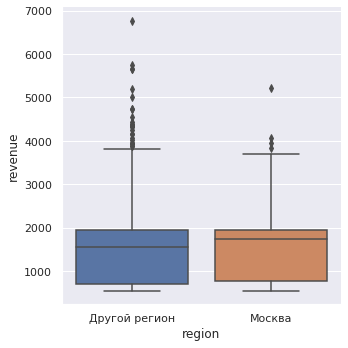

In [34]:
def region(city):
    '''
    Функция для указания нахождения пользователя. В случае Москвы вернуть "Москва",
    в ином случае вернуть "Другой регион"
    '''
    if city != 'Москва':
        return 'Другой регион'
    else:
        return 'Москва'

#применим функцию к отсортированному датафрейму
good_data['region'] = good_data['city'].apply(lambda x: region(x))
#выведем медианную выручку по столбцу region
print(good_data.pivot_table(index = 'region', values = 'revenue', aggfunc = 'median'))
# выведем диаграмму размаха
sns.catplot(x = 'region', y = 'revenue', data = good_data, kind = 'box');

### Промежуточный вывод

С помощью статистического теста мы не смогли опровергнуть гипотезу о равности доходов для пользователей города Москвы и других регионов. Таким образом, выручка с клиентов из Москвы практически не отличаются от выручки пользователей других регионов. Если мы не отвергаем нулевую гипотезу, то имеем вероятность ошибки вывода в 50.3%.

## Общий вывод

[В данной работе были изучены данные 500 пользователей «Мегалайна»](#1): кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Был проведен анализ поведения пользователей двух разных тарифов "Ультра" и "Смарт".

Первым делом была произведена [предобработка данных](#2), а именно проставлен правильный тип данных для дат. Добавлен столбец с номером месяца для таблиц. Округлены минуты разговоров в большую сторону. Тоже самое и для потребления интернет трафика.

[Далее](#3), выведена отдельная таблица по месяцам и пользователям с количеством сделанных звонков и израсходованных минут разговора, количетсвом отправленных сообщений и объемом расхода интернет-трафика. Далее, для пользователей каждого тарифа была посчитана и добавлена в таблицу выручка компании.

Был произведен [анализ даннных](#4), который подтвердил, что пользователи тарифа "Смарт" в среднем переплачивают больше сверх фиксированнной оплаты тарифа, чем пользователи другого тарифа. Для пользователей каждого тарифа был посчитан средний расход минут разговора, количества отправленных сообщений и потребляемого интернет-трафика.

[На 5 шаге](#5) был произведен статистический анализ выручки от тарифов "Ультра" и "Смарт". Сначала был проведен тест Левина. После была отвергнута гипотеза о равности выручек двух тарифов. Получилось, что в среднем пользоваватели тарифа "Ультра" платят **1950 рублей**, а пользователи тарифа "Смарт" **988 рублей** в месяц. Гипотеза о равности выручек клиентов из Москвы и других регионов не получилось отвергнуть. В среднем они платят одинаково.   
Критический уровень статистической значимости (`alpha`) был обозначен в 1%, т.к. выборка из пользователей размером в 500 человек.

Были обнаружены следующие инсайты:
- тарифы "Смарт" и "Ультра" приносят разную выручку компании "Мегалайн". В среднем клиенты тарифа "Ультра" приносят большую выручку;
- пользователи тарифа "Смарт" в среднем переплачивают 438 рублей (79.6%) сверх абонентской платы, т.к. им не хватает выделенных услуг в рамках тарифа;
- пользователи тарифа "Ультра" не использует включенные услуги в тариф в полном объеме;
- средняя выручка клиентов из Москвы не отличается от выручки клиентов из других регионов. Разница статистически незначима. Р-значение = 0.503, разница составляет 188 рублей (10.8%).